In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import importlib

from rul_adapt import evaluation
evaluation = importlib.reload(evaluation)
from rul_adapt.evaluation import load_runs, friedman_nemenyi, plot_critical_difference


In [2]:
runs = load_runs("rul-adapt/benchmark", exclude_tags=["pretraining"])
runs.head()

100%|██████████| 2220/2220 [00:22<00:00, 98.74run/s] 


,path,approach,replication_group,source,target,dataset,backbone,adaption_mode,test/source/score/dataloader_idx_0,test/target/score/dataloader_idx_1,test/source/rmse/dataloader_idx_0,test/target/rmse/dataloader_idx_1
0,rul-adapt/benchmark/jmodi4tj,PseudoLabelsApproach,f725d364-0fd1-477c-9e44-c0a665d2a94f,3,2,xjtu-sy,cnn,transductive,0.398625,0.295069,0.232357,0.222762
1,rul-adapt/benchmark/g9mn7d23,PseudoLabelsApproach,f725d364-0fd1-477c-9e44-c0a665d2a94f,3,2,xjtu-sy,cnn,transductive,0.242786,0.204328,0.216781,0.192241
2,rul-adapt/benchmark/271om1nj,PseudoLabelsApproach,f725d364-0fd1-477c-9e44-c0a665d2a94f,3,2,xjtu-sy,cnn,transductive,0.02745,0.036804,0.323559,0.3247
3,rul-adapt/benchmark/zucv17et,PseudoLabelsApproach,f725d364-0fd1-477c-9e44-c0a665d2a94f,3,2,xjtu-sy,cnn,transductive,0.094913,0.106798,0.27144,0.263322
4,rul-adapt/benchmark/658g6cao,PseudoLabelsApproach,f725d364-0fd1-477c-9e44-c0a665d2a94f,3,2,xjtu-sy,cnn,transductive,0.087195,0.121309,0.258556,0.250286


In [3]:
metric_name = "test/target/rmse/dataloader_idx_1"
types = runs[metric_name].apply(lambda x: type(x))
runs = runs.drop(index=runs.iloc[np.argwhere(types == str).squeeze(), :].index.tolist())
runs[metric_name] = runs[metric_name].astype(float)

In [4]:
pivoted_runs =runs.pivot_table(index=["adaption_mode", "backbone", "approach"], columns=["dataset", "source", "target"], values=[metric_name])
pivoted_runs

test/target/rmse/dataloader_idx_1  \
dataset                                                                   cmapss   
source                                                                         1   
target                                                                         2   
adaption_mode backbone approach                                                    
complete      cnn      ConditionalDannApproach                         42.999459   
                       ConditionalMmdApproach                          43.243681   
                       ConsistencyApproach                             50.268807   
                       DannApproach                                    42.877418   
                       LatentAlignApproach                             46.640548   
                       MmdApproach                                     46.390696   
                       PseudoLabelsApproach                            25.320085   
inductive     cnn      AdaRulApproach                                 560.647757   
                       ConditionalDannApproach                         42.961975   
                       ConditionalMmdApproach                          43.912222   
                       ConsistencyApproach                             55.027943   
                       DannApproach                                    42.618374   
                       LatentAlignApproach                             51.363493   
                       MmdApproach                                     45.949615   
                       PseudoLabelsApproach                            25.206197   
transductive  cnn      AdaRulApproach                                 726.197272   
                       ConditionalDannApproach                         42.835643   
                       ConditionalMmdApproach                          43.258583   
                       ConsistencyApproach                             52.434949   
                       DannApproach                                    42.358826   
                       LatentAlignApproach                             42.777638   
                       MmdApproach                                     45.869713   
                       PseudoLabelsApproach                            21.631646   
              lstm     ConditionalDannApproach                         40.475977   
                       ConditionalMmdApproach                          44.252320   
                       ConsistencyApproach                             42.052787   
                       DannApproach                                    39.744838   
                       LatentAlignApproach                             33.216183   
                       MmdApproach                                     44.076680   
                       PseudoLabelsApproach                            20.151070   

                                                                        \
dataset                                                                  
source                                                                   
target                                                   3           4   
adaption_mode backbone approach                                          
complete      cnn      ConditionalDannApproach   26.032054   43.917287   
                       ConditionalMmdApproach    32.455169   46.445274   
                       ConsistencyApproach       38.682765   49.678735   
                       DannApproach              25.980962   44.132130   
                       LatentAlignApproach       24.878564   52.340705   
                       MmdApproach               30.233892   46.458516   
                       PseudoLabelsApproach      20.652042   27.458483   
inductive     cnn      AdaRulApproach           535.286374  953.578043   
                       ConditionalDannApproach   28.122374   43.457541   
                       ConditionalMmdApproach    35.429537   44.832645

In [5]:
def approach_wise_versus(df, v1, v2, dataset="cmapss", decimal=1, alternative="greater"):
    df = df.filter(like=dataset, axis=1)
    approaches = df.index.get_level_values("approach").unique()
    versus_repr = f"{'/'.join(set(v1).symmetric_difference(v2))} - {alternative}"
    columns = pd.MultiIndex.from_product([[versus_repr], ["R+", "R-", "p-value"]])
    versus = pd.DataFrame(index=approaches, columns=columns)
    max_statistic = sum(range(1, len(df.columns) + 1))
    for approach in approaches:
        v1_data = df.loc[v1 + (approach,)]
        v2_data = df.loc[v2 + (approach,)]
        diff = (v1_data - v2_data).round(decimal)
        result = wilcoxon(diff, zero_method="zsplit", alternative=alternative)
        versus.loc[approach] = (result.statistic, max_statistic - result.statistic, result.pvalue)
        
    return versus

In [6]:
cleaned = pivoted_runs.drop(index=["AdaRulApproach"], level="approach")
approach_wise_versus(cleaned, ("transductive", "cnn"), ("inductive", "cnn"), dataset="xjtu-sy", decimal=6, alternative="greater")

transductive/inductive - greater             
                                                      R+   R- p-value
approach                                                             
ConditionalDannApproach                              NaN  NaN     NaN
ConditionalMmdApproach                               NaN  NaN     NaN
ConsistencyApproach                                  NaN  NaN     NaN
DannApproach                                         NaN  NaN     NaN
LatentAlignApproach                                  NaN  NaN     NaN
MmdApproach                                          NaN  NaN     NaN
PseudoLabelsApproach                                 NaN  NaN     NaN

In [7]:
cleaned = pivoted_runs.drop(index=["AdaRulApproach"], level="approach")
approach_wise_versus(cleaned, ("transductive", "cnn"), ("complete", "cnn"), decimal=2, alternative="two-sided")

complete/transductive - two-sided                
                                                       R+    R-   p-value
approach                                                                 
ConditionalDannApproach                              23.5  54.5  0.266113
ConditionalMmdApproach                                7.0  71.0  0.009277
ConsistencyApproach                                  34.0  44.0  0.733398
DannApproach                                         25.0  53.0   0.30127
LatentAlignApproach                                  18.0  60.0  0.109863
MmdApproach                                          38.0  40.0  0.969727
PseudoLabelsApproach                                 39.0  39.0       1.0

In [8]:
cleaned = pivoted_runs.drop(index=["AdaRulApproach"], level="approach")
approach_wise_versus(cleaned, ("transductive", "cnn"), ("transductive", "lstm"), alternative="two-sided")

cnn/lstm - two-sided                
                                          R+    R-   p-value
approach                                                    
ConditionalDannApproach                 36.5  41.5  0.850098
ConditionalMmdApproach                  34.0  44.0  0.733398
ConsistencyApproach                     38.0  40.0  0.969727
DannApproach                            24.5  53.5  0.266113
LatentAlignApproach                     29.0  49.0  0.469727
MmdApproach                             30.0  48.0  0.518555
PseudoLabelsApproach                    32.0  46.0   0.62207

In [9]:
def approach_wise_boxplot(df, v1, v2, dataset="cmapss"):
    approaches = df.index.get_level_values("approach").unique()
    versus_repr = f"{'/'.join(set(v1).symmetric_difference(v2))}"
    for approach in approaches:
        v1_data = df.loc[v1 + (approach,)].filter(like=dataset, axis=0)
        v2_data = df.loc[v2 + (approach,)].filter(like=dataset, axis=0)
        plt.boxplot([v1_data, v2_data], labels=[v1, v2])
        plt.scatter([1, 2], [v1_data.mean(), v2_data.mean()], color="red")
        plt.title(f"{approach} - {versus_repr}")
        plt.show()

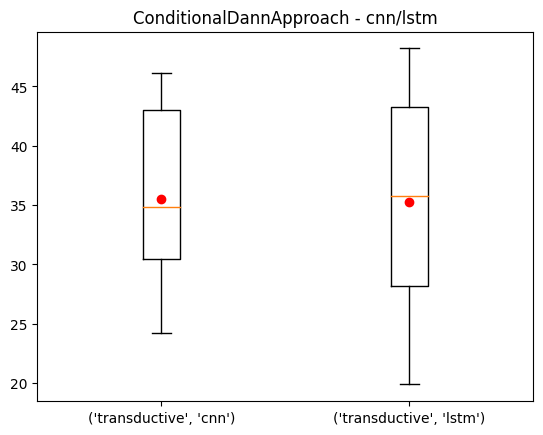

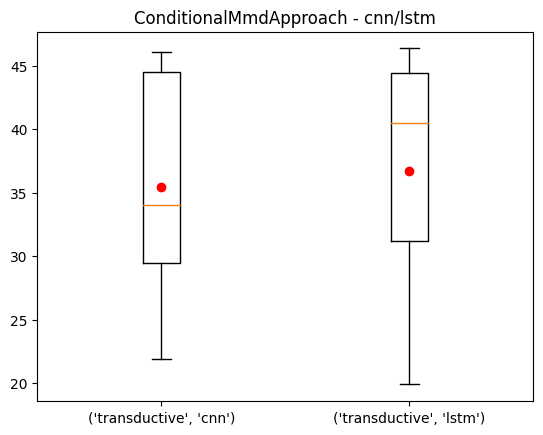

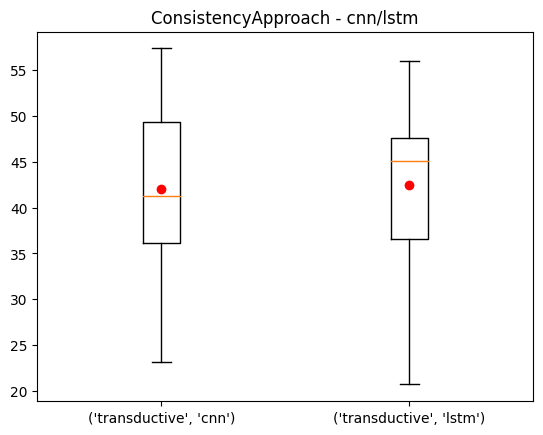

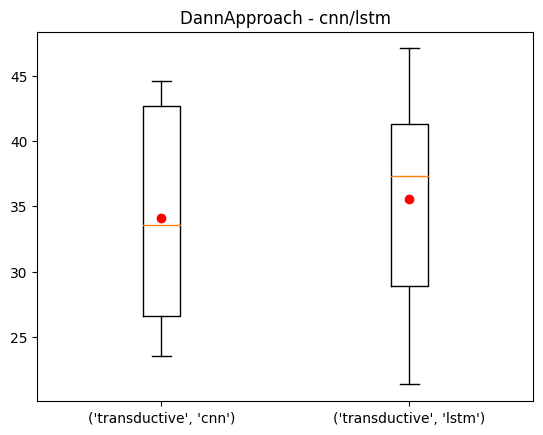

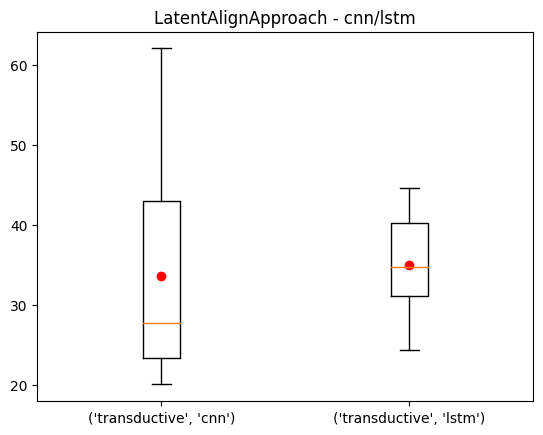

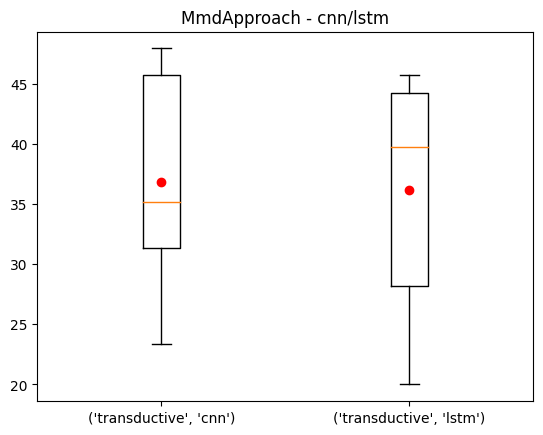

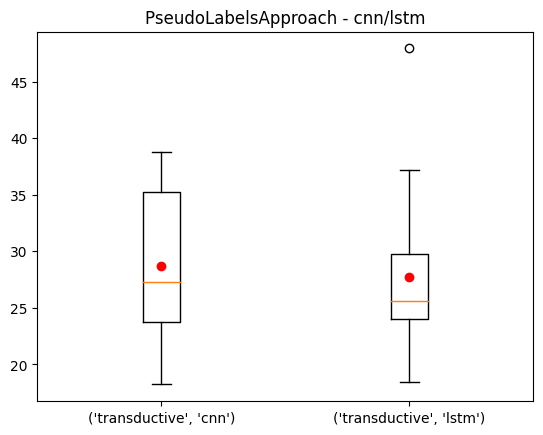

In [10]:
cleaned = pivoted_runs.drop(index=["AdaRulApproach"], level="approach")
approach_wise_boxplot(cleaned, ("transductive", "cnn"), ("transductive", "lstm"))

## Overall Results
* No real significant leader
* Pseudo Labels are best approach for RMSE
* Conditional DANN is best for Score
* CNN only

ConditionalDannApproach    3.708333
ConditionalMmdApproach     3.687500
ConsistencyApproach        5.416667
DannApproach               4.041667
LatentAlignApproach        3.187500
MmdApproach                4.812500
PseudoLabelsApproach       3.145833
dtype: float64

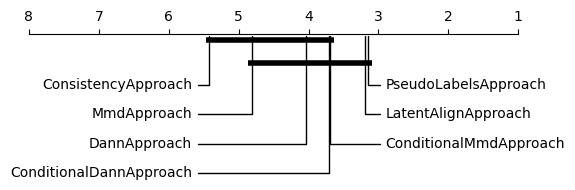

In [29]:
only_transductive = pivoted_runs.loc[("transductive", "cnn", slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
only_transductive = only_transductive.round(2)
only_transductive.index = only_transductive.index.droplevel(["adaption_mode", "backbone"])
only_transductive.columns = only_transductive.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
ranks, pairwise_significance = friedman_nemenyi(only_transductive)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
fig.savefig("overall_rmse.pdf", bbox_inches="tight")
ranks

## LSTM vs CNN
* Pseudo Labels still the best and consistency worst
* Order of remaining approaches shifts
* Some algorithms may be better suited for LSTM --> evaluation on both needed?
* Exchanging LatentAlignApproach with CNN in an LSTM setting improves its ranking --> consistent backbone is needed

ConditionalDannApproach    3.333333
ConditionalMmdApproach     4.666667
ConsistencyApproach        5.500000
DannApproach               4.083333
LatentAlignApproach        4.083333
MmdApproach                4.083333
PseudoLabelsApproach       2.250000
dtype: float64

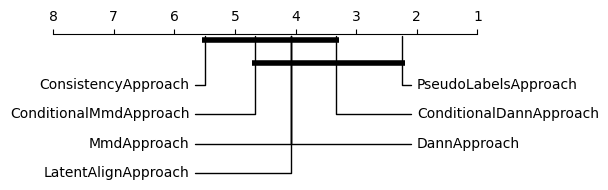

In [12]:
only_lstm = pivoted_runs.loc[("transductive", "lstm", slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
only_lstm = only_lstm.round(2)
only_lstm.index = only_lstm.index.droplevel(["adaption_mode", "backbone"])
only_lstm = only_lstm.drop(["femto", "xjtu-sy"], level="dataset", axis=1)
only_lstm.columns = only_lstm.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
ranks, pairwise_significance = friedman_nemenyi(only_lstm)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
# _ = fig.gca().set_title("LSTM Backbone")
fig.savefig("lstm_backbone.pdf", bbox_inches="tight")
ranks

ConditionalDannApproach    4.166667
ConditionalMmdApproach     4.333333
ConsistencyApproach        6.166667
DannApproach               3.250000
LatentAlignApproach        2.500000
MmdApproach                5.333333
PseudoLabelsApproach       2.250000
dtype: float64

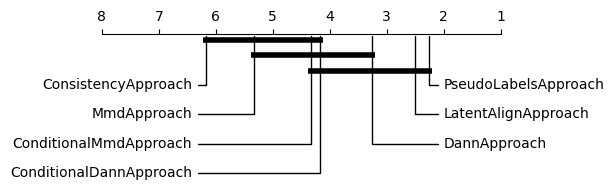

In [13]:
only_cnn = pivoted_runs.loc[("transductive", "cnn", slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
only_cnn = only_cnn.round(2)
only_cnn.index = only_cnn.index.droplevel(["adaption_mode", "backbone"])
only_cnn = only_cnn.drop(["femto", "xjtu-sy"], level="dataset", axis=1)
only_cnn.columns = only_cnn.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
ranks, pairwise_significance = friedman_nemenyi(only_cnn)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
# _ = fig.gca().set_title("CNN Backbone")
fig.savefig("cnn_backbone.pdf", bbox_inches="tight")
ranks

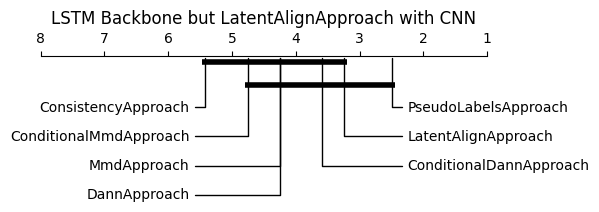

In [27]:
mixed = only_lstm.copy()
mixed.loc["LatentAlignApproach"] = only_cnn.loc["LatentAlignApproach"]
ranks, pairwise_significance = friedman_nemenyi(mixed)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
_ = fig.gca().set_title("LSTM Backbone but LatentAlignApproach with CNN")

# Inductive vs Transductive Rankings

ConditionalDannApproach    4.166667
ConditionalMmdApproach     4.333333
ConsistencyApproach        6.166667
DannApproach               3.250000
LatentAlignApproach        2.500000
MmdApproach                5.333333
PseudoLabelsApproach       2.250000
dtype: float64

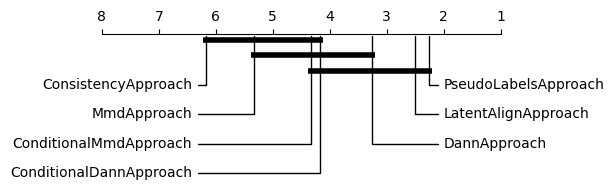

In [15]:
only_transductive = pivoted_runs.loc[("transductive", "cnn", slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
only_transductive = only_transductive.round(2)
only_transductive.index = only_transductive.index.droplevel(["adaption_mode", "backbone"])
only_transductive = only_transductive.drop(["femto", "xjtu-sy"], level="dataset", axis=1)
only_transductive.columns = only_transductive.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
ranks, pairwise_significance = friedman_nemenyi(only_transductive)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
# _ = fig.gca().set_title("CNN Backbone")
fig.savefig("transductive.pdf", bbox_inches="tight")
ranks

ConditionalDannApproach    3.666667
ConditionalMmdApproach     4.583333
ConsistencyApproach        6.500000
DannApproach               3.166667
LatentAlignApproach        2.666667
MmdApproach                5.083333
PseudoLabelsApproach       2.333333
dtype: float64

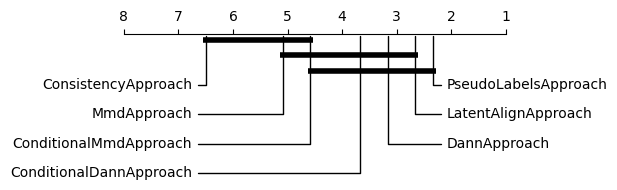

In [16]:
only_inductive = pivoted_runs.loc[("inductive", "cnn", slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
only_inductive = only_inductive.round(2)
only_inductive.index = only_inductive.index.droplevel(["adaption_mode", "backbone"])
only_inductive = only_inductive.drop(["femto", "xjtu-sy"], level="dataset", axis=1)
only_inductive.columns = only_inductive.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
ranks, pairwise_significance = friedman_nemenyi(only_inductive)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
# _ = fig.gca().set_title("CNN Backbone")
fig.savefig("inductive.pdf", bbox_inches="tight")
ranks

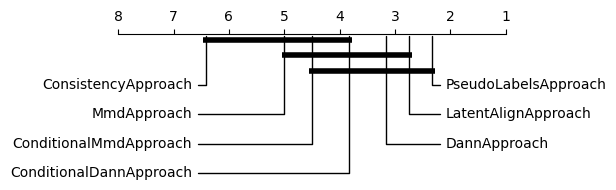

In [17]:
mixed = only_inductive.copy()
mixed.loc["ConditionalDannApproach"] = only_transductive.loc["ConditionalDannApproach"]
ranks, pairwise_significance = friedman_nemenyi(mixed)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
# _ = fig.gca().set_title("LSTM Backbone but LatentAlignApproach with CNN")

### Taskwise Comparison
* LSTM is better than CNN on harder transfer tasks (transfer to 2 or 4)
* CNN is better than LSTM on easier transfer tasks (transfer to 1 or 3)

/tmp/ipykernel_9171/2640424045.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axes = taskwise_cnn_lstm.boxplot(by="backbone", ax=ax_new)


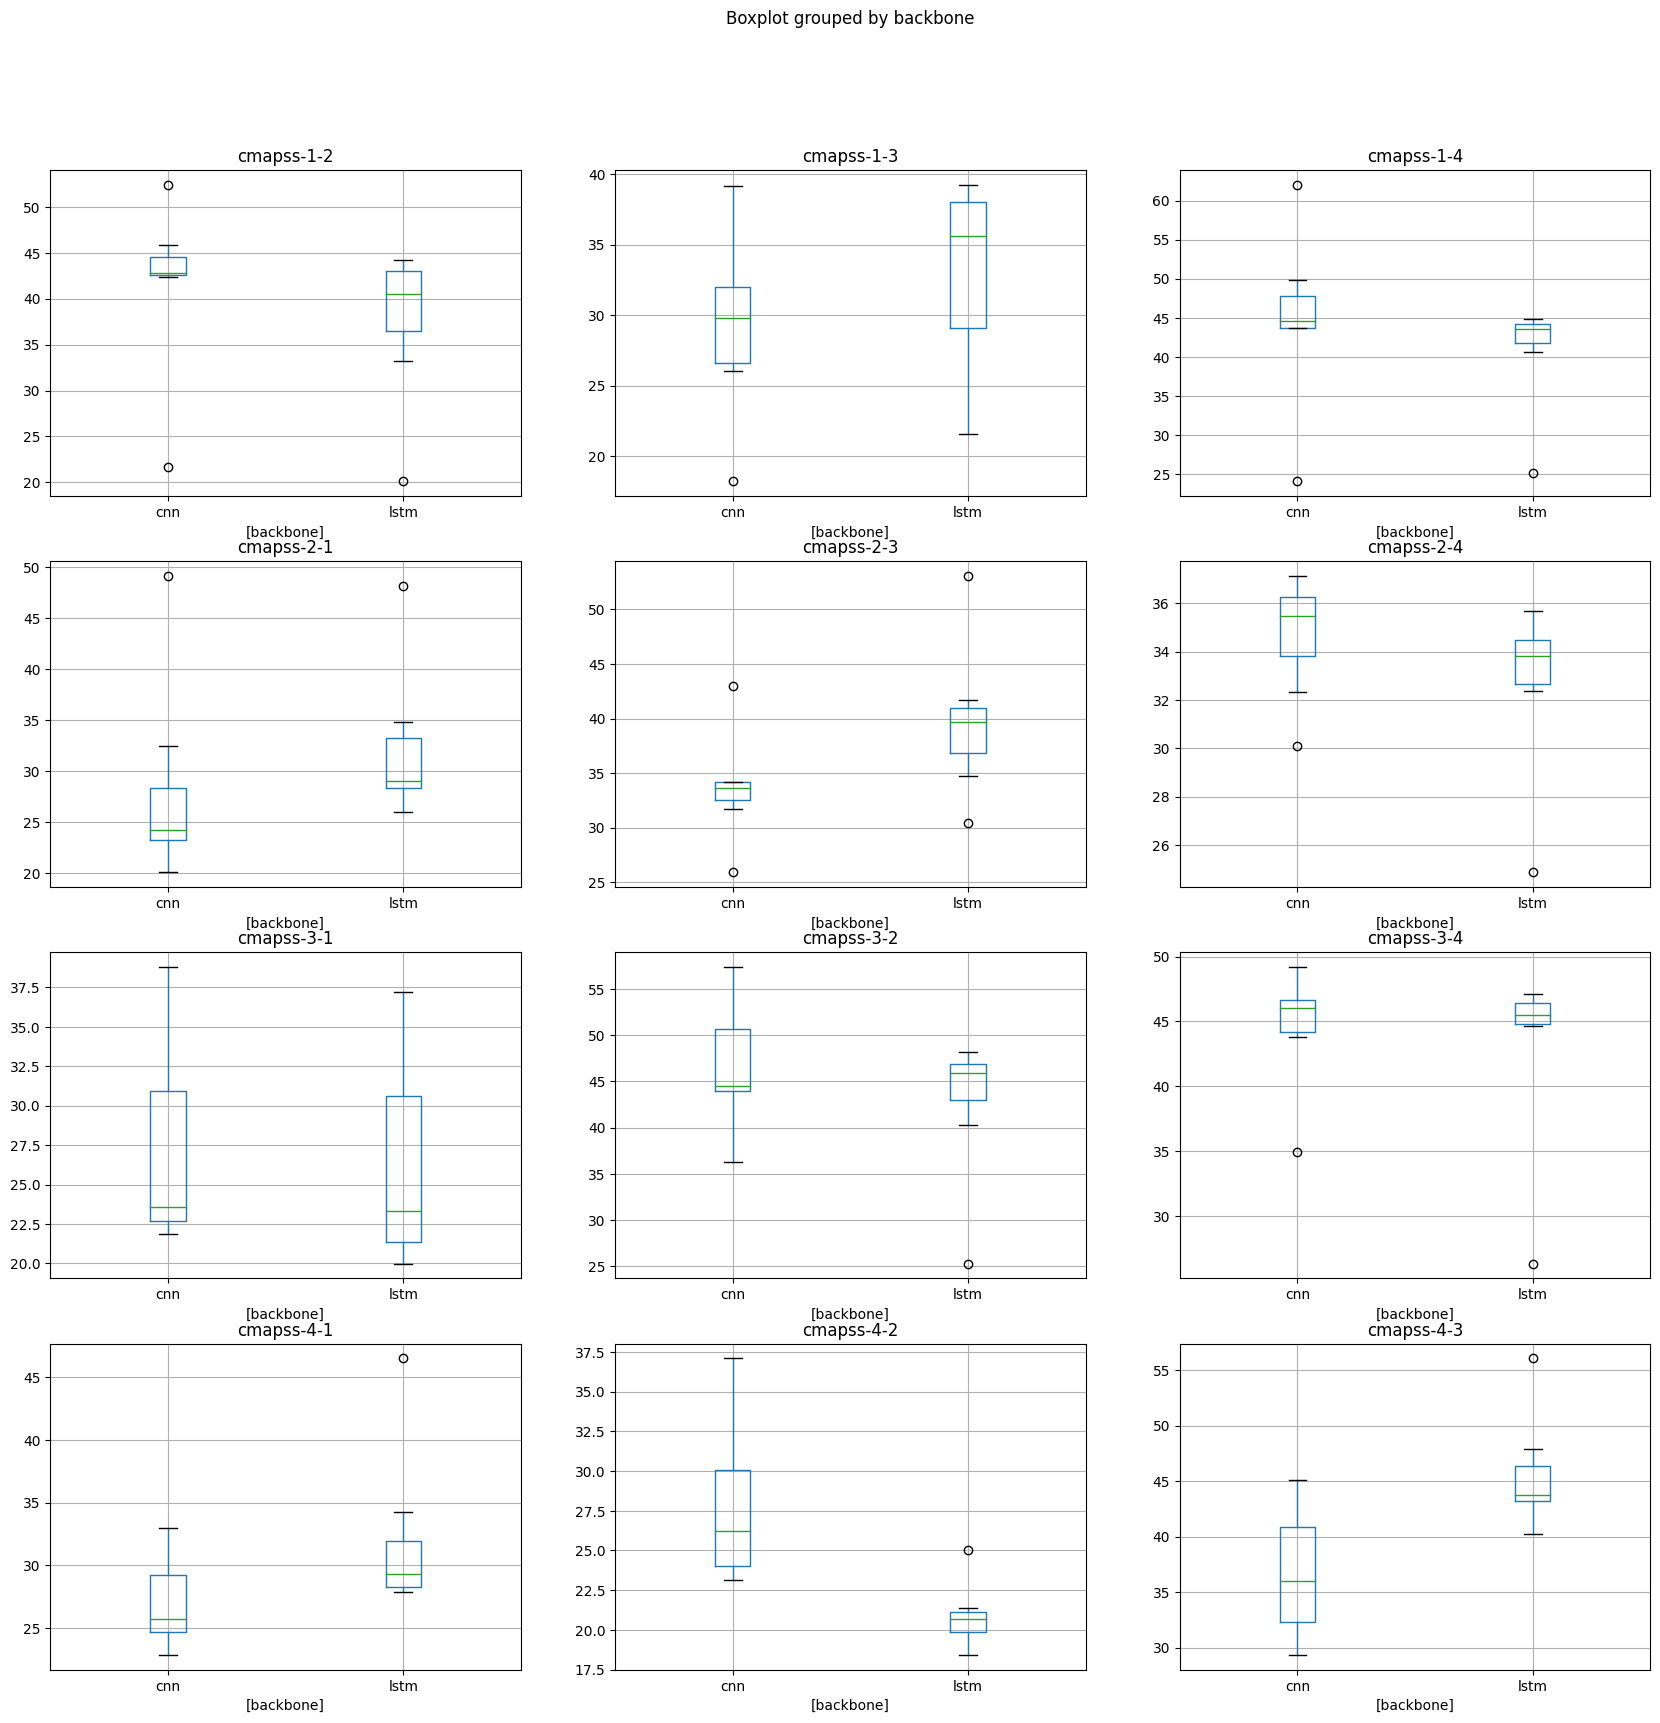

In [18]:
taskwise_cnn_lstm = pivoted_runs.loc[("transductive", slice(None), slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
taskwise_cnn_lstm = taskwise_cnn_lstm.round(2)
taskwise_cnn_lstm.index = taskwise_cnn_lstm.index.droplevel(["adaption_mode", "approach"])
taskwise_cnn_lstm = taskwise_cnn_lstm.drop(["femto", "xjtu-sy"], level="dataset", axis=1)
taskwise_cnn_lstm.columns = taskwise_cnn_lstm.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
fig, ax_new = plt.subplots(4, 3, sharey=False, figsize=(20, 20))
# [ax.set_yscale('log') for ax in ax_new.ravel()]
axes = taskwise_cnn_lstm.boxplot(by="backbone", ax=ax_new)

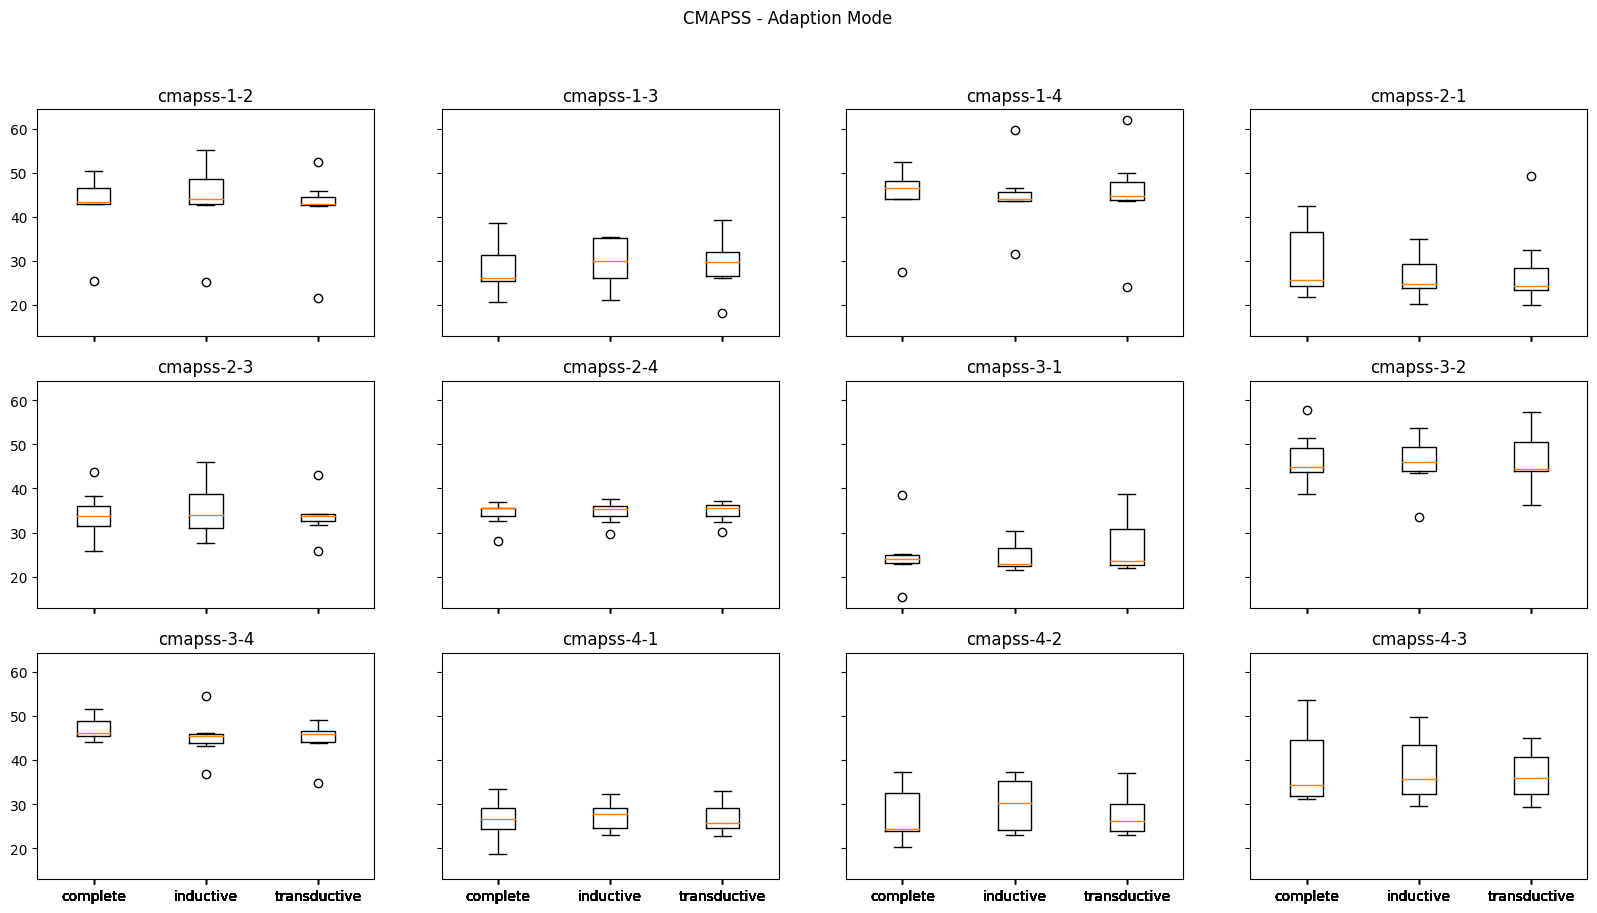

In [19]:
taskwise_adaption_mode = pivoted_runs.loc[(slice(None), "cnn", slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
taskwise_adaption_mode = taskwise_adaption_mode.round(2)
taskwise_adaption_mode.index = taskwise_adaption_mode.index.droplevel(["backbone", "approach"])
taskwise_adaption_mode = taskwise_adaption_mode.drop(["femto", "xjtu-sy"], level="dataset", axis=1)
taskwise_adaption_mode.columns = taskwise_adaption_mode.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
fig, axes = plt.subplots(3, 4, sharex="all", sharey="all", figsize=(20, 10))
for ax, task in zip(axes.flatten(), taskwise_adaption_mode.columns):
    groupby = taskwise_adaption_mode[task].groupby("adaption_mode")
    ax.boxplot([groupby.get_group(g) for g in groupby.groups.keys()], labels=groupby.groups.keys())
    ax.set_title(task)
_ = fig.suptitle("CMAPSS - Adaption Mode")

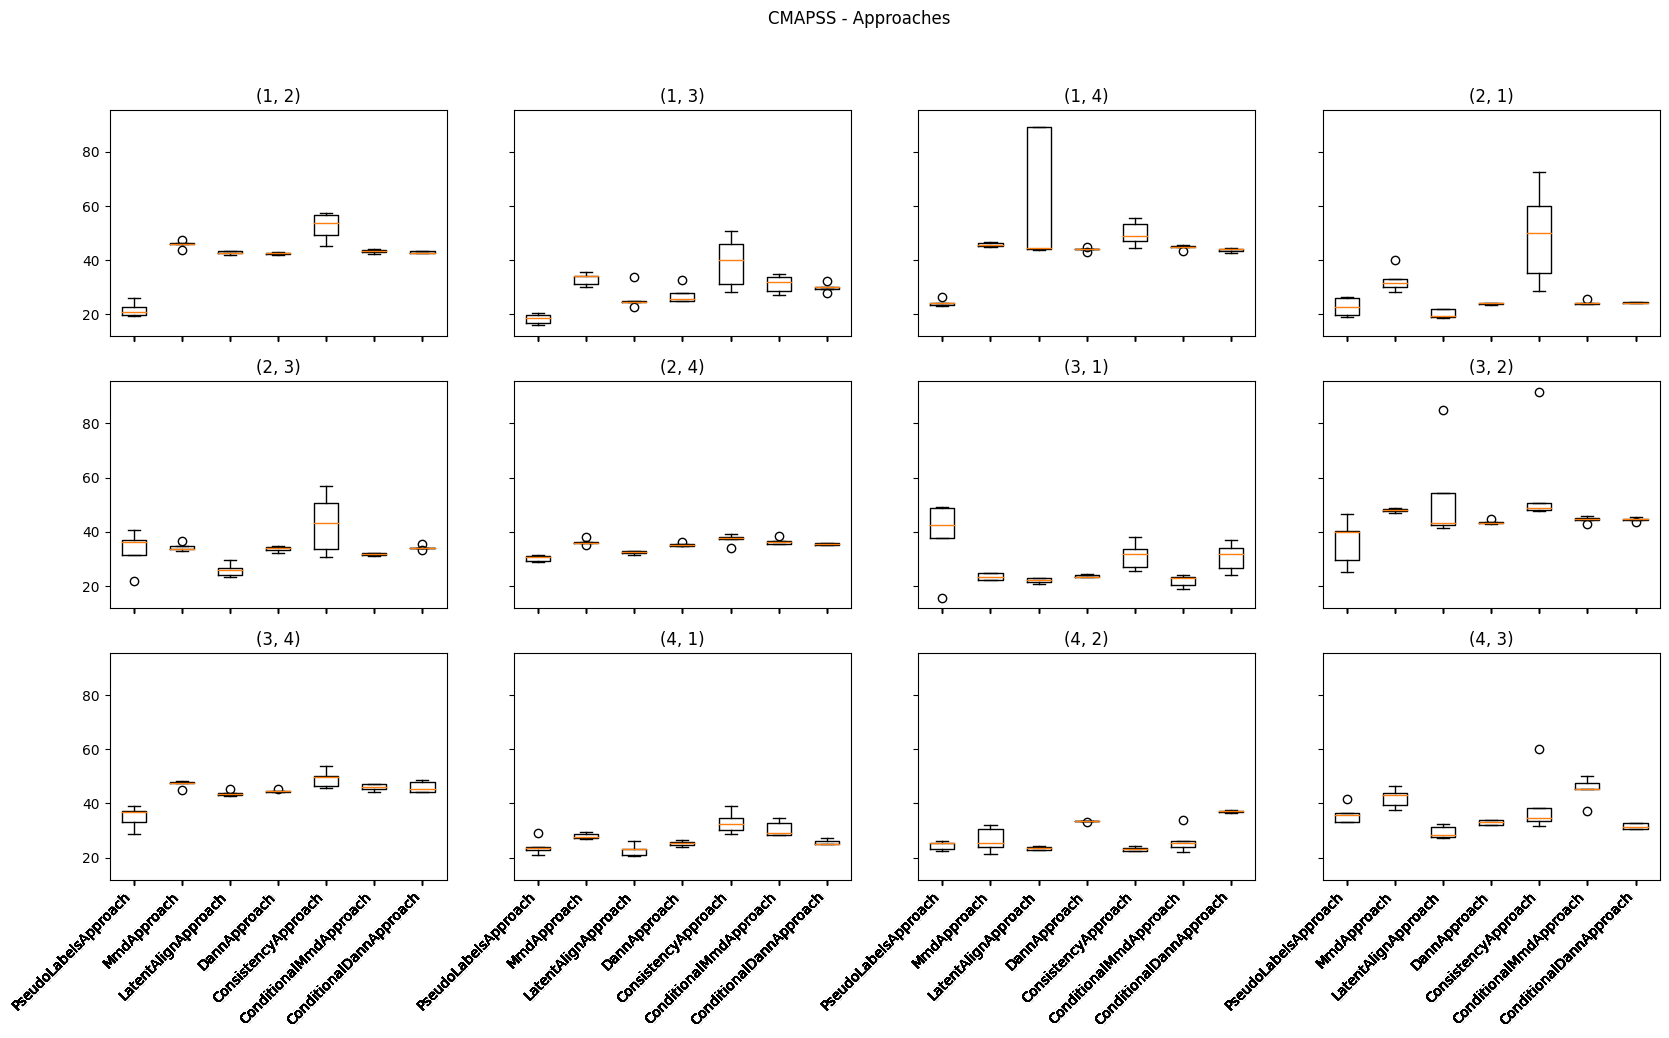

In [20]:
taskwise_approach = runs.set_index(["adaption_mode", "backbone", "approach", "dataset"])
taskwise_approach.drop(index=["AdaRulApproach"], level="approach", inplace=True)
taskwise_approach.drop(index=["femto", "xjtu-sy"], level="dataset", inplace=True)
taskwise_approach.drop(index=["inductive", "complete"], level="adaption_mode", inplace=True)
taskwise_approach.drop(index=["lstm"], level="backbone", inplace=True)
taskwise_approach.index = taskwise_approach.index.droplevel(["adaption_mode", "backbone", "dataset"])
taskwise_approach = taskwise_approach.round(2)
taskwise_approach = taskwise_approach.groupby(["source", "target"])
fig, axes = plt.subplots(3, 4, sharex="all", sharey="all", figsize=(20, 10))
for ax, task in zip(axes.flatten(), taskwise_approach.groups.keys()):
    ax: plt.Axes
    data = taskwise_approach.get_group(task)["test/target/rmse/dataloader_idx_1"]
    approaches = data.index.unique()
    ax.boxplot([data[approach] for approach in approaches], labels=approaches)
    ax.set_title(task)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")
_ = fig.suptitle("CMAPSS - Approaches")

In [21]:
def difference_distribution(df, v1, v2, **kwargs):
    datasets = df.columns.get_level_values("dataset").unique()
    versus_repr = f"{'/'.join(set(v1).symmetric_difference(v2))}"
    common = set(v1).intersection(v2)
    v1_repr = tuple(common.symmetric_difference(v1))
    v2_repr = tuple(common.symmetric_difference(v2))
    fig: plt.Figure = plt.figure(**kwargs)
    axes = fig.subplots(1, len(datasets))
    for dataset, ax in zip(datasets, axes):
        v1_data = df.loc[v1].filter(like=dataset, axis=1)
        v2_data = df.loc[v2].filter(like=dataset, axis=1)
        diff = (v1_data - v2_data)
        ax.violinplot(diff.values.ravel(), showmeans=True)
        pos = diff[diff > 0].count().sum()
        neg = diff[diff < 0].count().sum()
        draw = diff[diff == 0].count().sum()
        ax.annotate(f"Wins\n{pos} {v2_repr}\n{neg} {v1_repr}\n {draw} draw", xy=(0.05, 0.95), xycoords="axes fraction", ha="left", va="top")
        ax.set_xticks([1], [dataset])
    fig.suptitle(versus_repr)
        
    return fig

/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


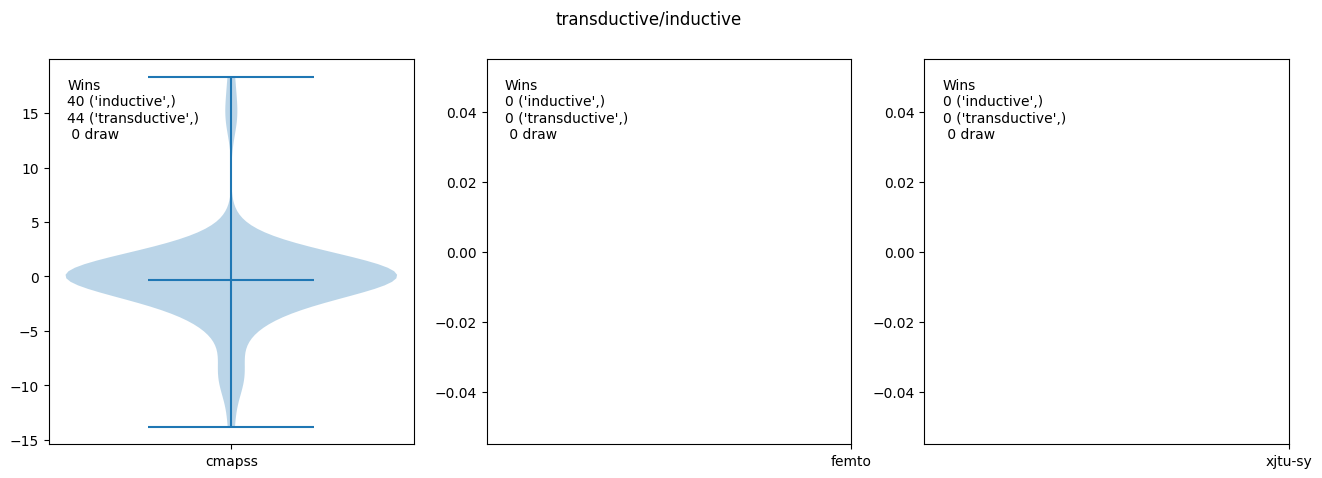

In [22]:
cleaned = pivoted_runs.drop(index=["AdaRulApproach"], level="approach")
fig = difference_distribution(cleaned, ("transductive", "cnn"), ("inductive", "cnn"), figsize=(16, 5))

In [23]:
lat_dann = pivoted_runs.loc[("transductive", slice(None), ["LatentAlignApproach", "DannApproach"]), :]
lat_dann.index = lat_dann.index.droplevel(["adaption_mode"])
lat_dann.index = lat_dann.index.map(lambda x: f"{x[0]}-{x[1]}")
lat_dann = lat_dann.drop(["femto", "xjtu-sy"], level="dataset", axis=1)
lat_dann.columns = lat_dann.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
ranks, _ = friedman_nemenyi(lat_dann)
ranks

Friedman test: No significant difference between approaches.


cnn-LatentAlignApproach     1.916667
lstm-LatentAlignApproach    2.750000
cnn-DannApproach            2.500000
lstm-DannApproach           2.833333
dtype: float64

In [25]:
metric_name = "test/target/score/dataloader_idx_1"
types = runs[metric_name].apply(lambda x: type(x))
runs = runs.drop(index=runs.iloc[np.argwhere(types == str).squeeze(), :].index.tolist())
runs[metric_name] = runs[metric_name].astype(float)
pivoted_scores =runs.pivot_table(index=["adaption_mode", "backbone", "approach"], columns=["dataset", "source", "target"], values=["test/target/score/dataloader_idx_1"])
pivoted_scores.loc[:, (slice(None), ["femto", "xjtu-sy"])] *= -1
pivoted_scores

test/target/score/dataloader_idx_1  \
dataset                                                                    cmapss   
source                                                                          1   
target                                                                          2   
adaption_mode backbone approach                                                     
complete      cnn      ConditionalDannApproach                       6.931521e+04   
                       ConditionalMmdApproach                        1.089294e+05   
                       ConsistencyApproach                           9.911325e+06   
                       DannApproach                                  6.603511e+04   
                       LatentAlignApproach                           2.724421e+05   
                       MmdApproach                                   4.103068e+05   
                       PseudoLabelsApproach                          8.156770e+03   
inductive     cnn      AdaRulApproach                                9.536295e+31   
                       ConditionalDannApproach                       7.272971e+04   
                       ConditionalMmdApproach                        1.813062e+05   
                       ConsistencyApproach                           5.093027e+07   
                       DannApproach                                  6.619592e+04   
                       LatentAlignApproach                           3.011319e+05   
                       MmdApproach                                   2.836637e+05   
                       PseudoLabelsApproach                          4.743405e+03   
transductive  cnn      AdaRulApproach                                         NaN   
                       ConditionalDannApproach                       7.017372e+04   
                       ConditionalMmdApproach                        8.032806e+04   
                       ConsistencyApproach                           1.058948e+08   
                       DannApproach                                  5.833176e+04   
                       LatentAlignApproach                           9.430371e+04   
                       MmdApproach                                   3.362902e+05   
                       PseudoLabelsApproach                          6.237358e+03   
              lstm     ConditionalDannApproach                       5.013397e+04   
                       ConditionalMmdApproach                        5.194511e+04   
                       ConsistencyApproach                           7.375339e+04   
                       DannApproach                                  3.867193e+04   
                       LatentAlignApproach                           6.509409e+04   
                       MmdApproach                                   9.376657e+04   
                       PseudoLabelsApproach                          1.964416e+03   

                                                                            \
dataset                                                                      
source                                                                       
target                                                     3             4   
adaption_mode backbone approach                                              
complete      cnn      ConditionalDannApproach  2.781629e+03  5.975040e+04   
                       ConditionalMmdApproach   5.087505e+03  6.596046e+05   
                       ConsistencyApproach      1.264511e+06  4.542239e+08   
                       DannApproach             3.451726e+03  1.195758e+05   
                       LatentAlignApproach      1.661370e+03  3.494470e+05   
                       MmdApproach              2.928903e+06  3.513906e+05   
                       PseudoLabelsApproach     5.738255e+03  1.369698e+04   
inductive     cnn      AdaRulApproach           1.816833e+31           NaN   
                       ConditionalDannApproach  2.273622e

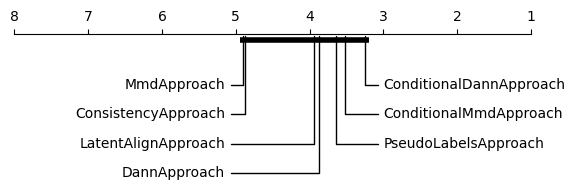

In [30]:
only_transductive = pivoted_scores.loc[("transductive", "cnn", slice(None)), :].drop(index=["AdaRulApproach"], level="approach")
only_transductive = only_transductive.round(2)
only_transductive.index = only_transductive.index.droplevel(["adaption_mode", "backbone"])
only_transductive.columns = only_transductive.columns.map(lambda x: f"{x[1]}-{x[2]}-{x[3]}")
ranks, pairwise_significance = friedman_nemenyi(only_transductive)
fig = plot_critical_difference(ranks, pairwise_significance, annotation_ratio=0.6, figsize=(6, 2))
fig.savefig("overall_score.pdf", bbox_inches="tight")